## Data Preprocessing

Downloading dataset in their original form

In [1]:
! curl "https://raw.githubusercontent.com/saifulislampi/sb-community-survey-22/main/sb-community-survey.csv" -o sb-community-survey.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257k  100  257k    0     0   750k      0 --:--:-- --:--:-- --:--:--  753k


In [2]:
! curl "https://raw.githubusercontent.com/saifulislampi/sb-community-survey-22/main/historic_shooting_data.csv" -o historic-shooting-data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46643  100 46643    0     0   147k      0 --:--:-- --:--:-- --:--:--  148k


Import necessary libraries

In [43]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

rng_seed = 42
pd.options.mode.chained_assignment = None

Read csv into dataframe

In [44]:
survey = pd.read_csv("sb-community-survey.csv")
shooting_data = pd.read_csv("historic-shooting-data.csv")

In [45]:
survey.head()

,_Q1[01]__[1__Overall_quality_of_life_in_y,Q1[02]__[2__Leadership_of_elected_offici,Q1[03]__[3__Overall_quality_of_local_gov,Q1[04]__[4__Communication_of_opportuniti,Q1[05]__[5__Overall_value_you_receive_fo,Q1[06]__[6__Level_of_public_involvement,Q1[07]__[7__Overall_quality_of_public_sc,Q1[08]__[8__Overall_quality_of_community,Q1[09]__[9__Overall_efforts_to_improve_h,Q2[01]__[1__As_a_place_to_live],...,Q45__How_would_you_compare_your_standard,Block_Address,City,State,Zip,District,Block_Lon,Block_Lat,Respondent_ID,OBJECTID
0,2,1,1,2,1,1,1,3,1,1,...,2,800 South 26th Street ...,South Bend,IN,46615,3,-86211000.0,41666000.0,1,0
1,5,4,4,4,5,4,1,5,4,5,...,5,1600 Belmont Avenue ...,South Bend,IN,46615,3,-86223000.0,41670000.0,2,1
2,2,1,1,2,2,1,1,1,1,2,...,2,2100 N Brookfield St ...,South Bend,IN,46628,1,-86278000.0,41706000.0,3,2
3,4,1,3,3,2,3,1,4,2,2,...,5,500 S Saint Joseph St ...,South Bend,IN,46601,2,-86249000.0,41671000.0,4,3
4,5,2,3,3,4,3,9,9,2,5,...,4,300 Tonti St ...,South Bend,IN,46617,4,-86255000.0,41691000.0,5,4


###Preparing the merged dataset

The column name in the survey has the full question name. We are renaming it to simplify preprocessing.

In [46]:
def rename_columns(col_name):
    new_name = col_name.split("__")[0]

    new_name_parts = new_name.split("_")

    if len(new_name_parts) > 1 and str(new_name).startswith('Q'):
      return new_name_parts[0]
    elif len(new_name_parts) > 1 and not str(new_name).startswith('Q'):
      return new_name_parts[1]
    else:
      return new_name

survey.columns = [rename_columns(col) for col in survey.columns]

In [47]:
survey.head()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q2[01],...,Q45,Address,City,State,Zip,District,Lon,Lat,ID,OBJECTID
0,2,1,1,2,1,1,1,3,1,1,...,2,800 South 26th Street ...,South Bend,IN,46615,3,-86211000.0,41666000.0,1,0
1,5,4,4,4,5,4,1,5,4,5,...,5,1600 Belmont Avenue ...,South Bend,IN,46615,3,-86223000.0,41670000.0,2,1
2,2,1,1,2,2,1,1,1,1,2,...,2,2100 N Brookfield St ...,South Bend,IN,46628,1,-86278000.0,41706000.0,3,2
3,4,1,3,3,2,3,1,4,2,2,...,5,500 S Saint Joseph St ...,South Bend,IN,46601,2,-86249000.0,41671000.0,4,3
4,5,2,3,3,4,3,9,9,2,5,...,4,300 Tonti St ...,South Bend,IN,46617,4,-86255000.0,41691000.0,5,4


In [48]:
shooting_data['Zip'] = shooting_data['Zip'].astype(str).str.replace('.0', '', regex=False)
shooting_data.head()

,Block Address,Date,Fatal,Year,Month,Zip
0,"700 S 27th St., South Bend, IN",2015/05/16,No,2015,May,46615
1,"1000 N Adams St., South Bend, IN",2015/08/17,No,2015,Aug,46628
2,"1200 N Adams St., South Bend, IN",2015/12/08,No,2015,Dec,46628
3,"500 N Allen St., South Bend, IN",2015/12/26,No,2015,Dec,46616
4,"1400 N Bendix Dr., South Bend, IN",2015/03/24,Yes,2015,Mar,46628


We created a new dataset from shooting count per zip code

In [49]:
shooting_data = shooting_data[shooting_data['Zip'] != 'nan']

shooting_data['Fatal'] = shooting_data['Fatal'].map({'Yes': 1, 'No': 0})

shooting_counts = shooting_data.groupby(['Zip', 'Fatal']).size().unstack(fill_value=0)

shooting_counts.columns = ['Non-Fatal', 'Fatal']

shooting_counts['Total Shootings'] = shooting_counts['Non-Fatal'] + shooting_counts['Fatal']

shooting_counts.reset_index(inplace=True)

shooting_counts

,Zip,Non-Fatal,Fatal,Total Shootings
0,46030,1,0,1
1,46350,1,0,1
2,46544,7,1,8
3,46556,1,0,1
4,46601,40,6,46
5,46613,95,13,108
6,46614,32,6,38
7,46615,27,10,37
8,46616,32,9,41
9,46617,39,9,48


In [50]:
shooting_counts.isna().sum()

Zip                0
Non-Fatal          0
Fatal              0
Total Shootings    0
dtype: int64

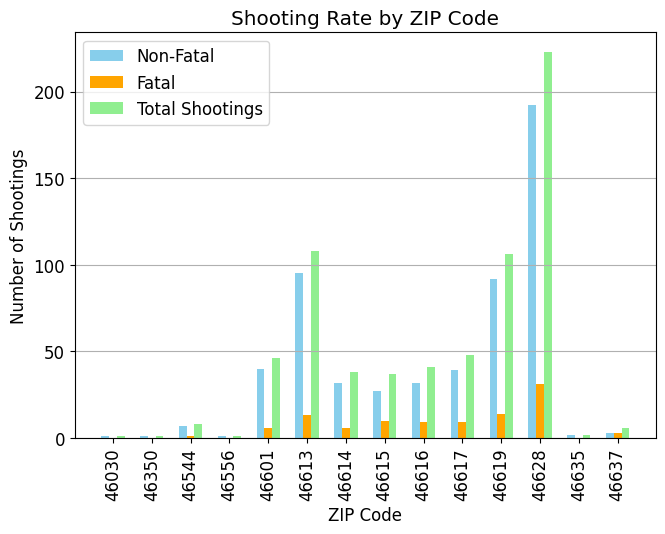

In [51]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (6.54, 6.54*0.8)

fig, ax = plt.subplots()

# Width of a bar
width = 0.2

# Positions of the bars on the x-axis
r1 = range(len(shooting_counts))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

# Creating the bars
ax.bar(r1, shooting_counts['Non-Fatal'], color='skyblue', width=width, label='Non-Fatal')
ax.bar(r2, shooting_counts['Fatal'], color='orange', width=width, label='Fatal')
ax.bar(r3, shooting_counts['Total Shootings'], color='lightgreen', width=width, label='Total Shootings')

# Adding names on the x-axis
plt.xlabel('ZIP Code')
plt.ylabel('Number of Shootings')
plt.title('Shooting Rate by ZIP Code')
plt.xticks([r + width for r in range(len(shooting_counts))], shooting_counts['Zip'], rotation=90)
plt.legend(loc='upper left')
plt.grid(axis='y')
plt.savefig("shootingByZip.png", dpi=600)
plt.show()


In [52]:
shooting_counts.to_csv("shooting-count-by-zip.csv", index=False)

In [53]:
shooting_counts['Zip'] = shooting_counts['Zip'].astype(str)
survey['Zip'] = survey['Zip'].astype(str)


We merged shooting data with our survey data by zip code.

In [54]:
merged_data = pd.merge(survey, shooting_counts, on='Zip', how='left')
merged_data.head()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q2[01],...,State,Zip,District,Lon,Lat,ID,OBJECTID,Non-Fatal,Fatal,Total Shootings
0,2,1,1,2,1,1,1,3,1,1,...,IN,46615,3,-86211000.0,41666000.0,1,0,27.0,10.0,37.0
1,5,4,4,4,5,4,1,5,4,5,...,IN,46615,3,-86223000.0,41670000.0,2,1,27.0,10.0,37.0
2,2,1,1,2,2,1,1,1,1,2,...,IN,46628,1,-86278000.0,41706000.0,3,2,192.0,31.0,223.0
3,4,1,3,3,2,3,1,4,2,2,...,IN,46601,2,-86249000.0,41671000.0,4,3,40.0,6.0,46.0
4,5,2,3,3,4,3,9,9,2,5,...,IN,46617,4,-86255000.0,41691000.0,5,4,39.0,9.0,48.0


In [55]:
merged_data.to_csv("survey_and_shooting_merged.csv")

### Preparing final dataset from merged dataset

In [56]:
data = merged_data.copy()

In [57]:
data.head()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q2[01],...,State,Zip,District,Lon,Lat,ID,OBJECTID,Non-Fatal,Fatal,Total Shootings
0,2,1,1,2,1,1,1,3,1,1,...,IN,46615,3,-86211000.0,41666000.0,1,0,27.0,10.0,37.0
1,5,4,4,4,5,4,1,5,4,5,...,IN,46615,3,-86223000.0,41670000.0,2,1,27.0,10.0,37.0
2,2,1,1,2,2,1,1,1,1,2,...,IN,46628,1,-86278000.0,41706000.0,3,2,192.0,31.0,223.0
3,4,1,3,3,2,3,1,4,2,2,...,IN,46601,2,-86249000.0,41671000.0,4,3,40.0,6.0,46.0
4,5,2,3,3,4,3,9,9,2,5,...,IN,46617,4,-86255000.0,41691000.0,5,4,39.0,9.0,48.0


In [58]:
data.isnull().sum()

Q1[01]             0
Q1[02]             0
Q1[03]             0
Q1[04]             0
Q1[05]             0
                  ..
ID                 0
OBJECTID           0
Non-Fatal          5
Fatal              5
Total Shootings    5
Length: 168, dtype: int64

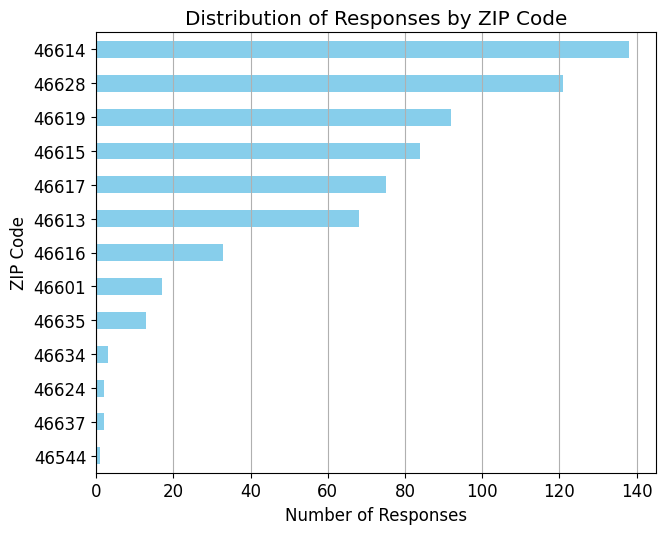

In [59]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (6.54, 6.54*0.8)

# Plotting a bar chart for ZIP code distribution
zip_code_counts= data['Zip'].value_counts()
zip_code_counts.sort_values().plot.barh(color='skyblue')
plt.title('Distribution of Responses by ZIP Code')
plt.xlabel('Number of Responses')
plt.ylabel('ZIP Code')
plt.grid(axis='x')
plt.savefig("ResponsesByZip.png", dpi=600)
plt.show()


In [60]:
(zip_code_counts/649)*100

Zip
46614    21.263482
46628    18.644068
46619    14.175655
46615    12.942989
46617    11.556240
46613    10.477658
46616     5.084746
46601     2.619414
46635     2.003082
46634     0.462250
46637     0.308166
46624     0.308166
46544     0.154083
Name: count, dtype: float64

To create our target variable "overall_rating" we follow these steps -

*   We create a new column "overall_rating" from the mean of Q2 columns
*   We turn that overall_rating into a categrorial column
*   We drop original Q2 columns



In [61]:
q2_columns = ['Q2[01]', 'Q2[02]', 'Q2[03]', 'Q2[04]', 'Q2[05]', 'Q2[06]', 'Q2[07]']

data['overall_rating'] = data[q2_columns].mean(axis=1)

median_sum_rating = data['overall_rating'].median()

data['overall_rating'] = (data['overall_rating'] >= median_sum_rating).astype(int)

data.drop(columns=q2_columns, inplace=True)

data.head()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q3,...,Zip,District,Lon,Lat,ID,OBJECTID,Non-Fatal,Fatal,Total Shootings,overall_rating
0,2,1,1,2,1,1,1,3,1,9,...,46615,3,-86211000.0,41666000.0,1,0,27.0,10.0,37.0,0
1,5,4,4,4,5,4,1,5,4,10,...,46615,3,-86223000.0,41670000.0,2,1,27.0,10.0,37.0,1
2,2,1,1,2,2,1,1,1,1,1,...,46628,1,-86278000.0,41706000.0,3,2,192.0,31.0,223.0,0
3,4,1,3,3,2,3,1,4,2,3,...,46601,2,-86249000.0,41671000.0,4,3,40.0,6.0,46.0,0
4,5,2,3,3,4,3,9,9,2,8,...,46617,4,-86255000.0,41691000.0,5,4,39.0,9.0,48.0,1


In [62]:
data.head()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q3,...,Zip,District,Lon,Lat,ID,OBJECTID,Non-Fatal,Fatal,Total Shootings,overall_rating
0,2,1,1,2,1,1,1,3,1,9,...,46615,3,-86211000.0,41666000.0,1,0,27.0,10.0,37.0,0
1,5,4,4,4,5,4,1,5,4,10,...,46615,3,-86223000.0,41670000.0,2,1,27.0,10.0,37.0,1
2,2,1,1,2,2,1,1,1,1,1,...,46628,1,-86278000.0,41706000.0,3,2,192.0,31.0,223.0,0
3,4,1,3,3,2,3,1,4,2,3,...,46601,2,-86249000.0,41671000.0,4,3,40.0,6.0,46.0,0
4,5,2,3,3,4,3,9,9,2,8,...,46617,4,-86255000.0,41691000.0,5,4,39.0,9.0,48.0,1


In [63]:
data.to_csv("final-dataset.csv")

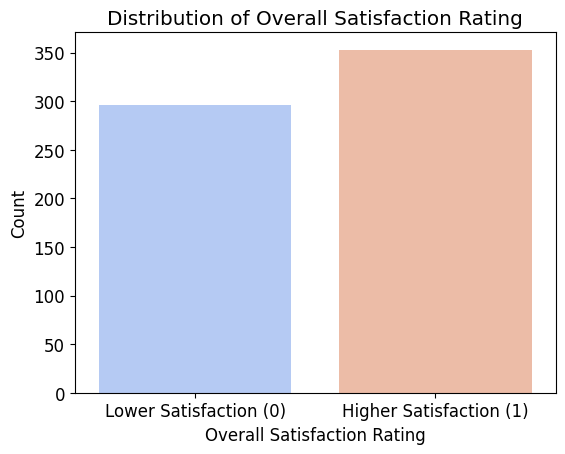

In [64]:
import seaborn as sns

# Example data and settings
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (5.54, 5.54*0.8)

# Plotting the distribution of the overall rating (binary: 0 or 1)
sns.countplot(x='overall_rating', data=data, hue='overall_rating', palette='coolwarm', legend=False)
plt.title('Distribution of Overall Satisfaction Rating')
plt.xlabel('Overall Satisfaction Rating')
plt.ylabel('Count')
plt.xticks([0, 1], ['Lower Satisfaction (0)', 'Higher Satisfaction (1)'])
plt.savefig("SatisfactionDist.png", dpi=600)
plt.show()

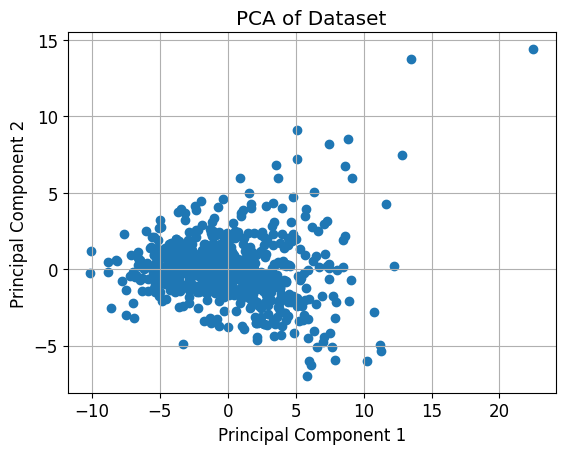

In [65]:
numerical_features = data.select_dtypes(include=np.number).drop(['District', 'Lon', 'Lat', 'ID', 'OBJECTID'], axis=1)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features.fillna(numerical_features.mean()))

# Performing PCA
pca = PCA(n_components=2)  # Reducing to 2 principal components
principal_components = pca.fit_transform(scaled_features)

principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Plotting the PCA results
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (5.54, 5.54*0.8)

plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.grid(True)
plt.show()


In [66]:
numerical_features.describe()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q3,...,Q43[04],Q43[05],Q43[06],Q43[07],Q44,Q45,Non-Fatal,Fatal,Total Shootings,overall_rating
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,...,391.0,1.0,96.0,8.0,649.000000,649.0000,644.000000,644.000000,644.000000,649.000000
mean,3.332820,3.015408,3.274268,3.132512,2.758089,3.124807,2.671803,3.619414,2.804314,13.738059,...,4.0,5.0,6.0,7.0,3.661017,3.5547,76.925466,13.465839,90.391304,0.543914
std,1.094396,1.471879,1.440797,1.652068,1.456690,1.876960,2.124626,1.819389,1.986897,25.793921,...,0.0,NaN,0.0,0.0,1.135444,1.5567,61.345444,8.973457,70.113387,0.498452
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.0,5.0,6.0,7.0,1.000000,1.0000,2.000000,0.000000,2.000000,0.000000
25%,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,5.000000,...,4.0,5.0,6.0,7.0,3.000000,3.0000,32.000000,6.000000,38.000000,0.000000
50%,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,6.000000,...,4.0,5.0,6.0,7.0,4.000000,3.0000,39.000000,10.000000,48.000000,1.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,8.000000,...,4.0,5.0,6.0,7.0,4.000000,4.0000,95.000000,14.000000,108.000000,1.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,99.000000,...,4.0,5.0,6.0,7.0,9.000000,9.0000,192.000000,31.000000,223.000000,1.000000


### Impact of shooting on overall rating

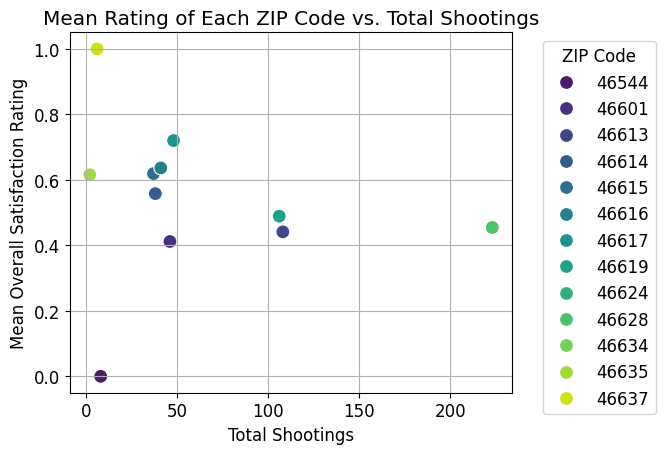

In [67]:
# Grouping data by 'Zip' to calculate the mean overall rating and total shootings
zip_grouped = data.groupby('Zip').agg({
    'overall_rating': 'mean',  # Calculating mean overall satisfaction rating
    'Total Shootings': 'first'   # Summing up total shootings
}).reset_index()

# Renaming columns for clarity in the plot
zip_grouped.rename(columns={'overall_rating': 'Mean Overall Rating', 'Total Shootings': 'Total Shootings'}, inplace=True)

# Plotting
# Example data and settings
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (6.54, 5.54*0.8)

sns.scatterplot(data=zip_grouped, x='Total Shootings', y='Mean Overall Rating', hue='Zip', palette='viridis', s=100)
plt.title('Mean Rating of Each ZIP Code vs. Total Shootings')
plt.xlabel('Total Shootings')
plt.ylabel('Mean Overall Satisfaction Rating')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.savefig("shootingVSSatisfaction.png", dpi=600)
plt.show()



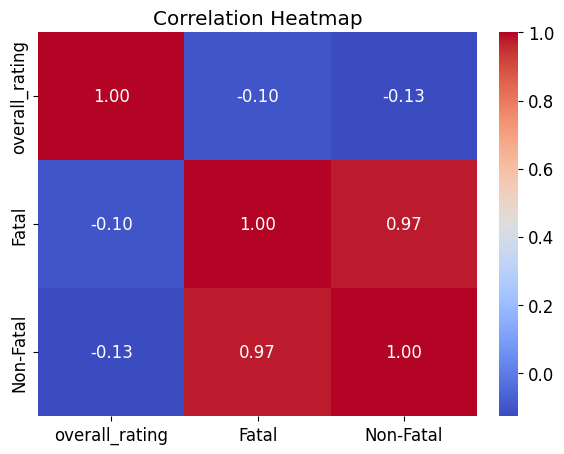

In [68]:
columns = ['overall_rating', 'Fatal', 'Non-Fatal']

data_for_heatmap = data[columns]
correlation_matrix = data_for_heatmap.corr()

# Create the heatmap
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (5.54, 5.54*0.8)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=columns, yticklabels=columns)
plt.title('Correlation Heatmap')
plt.savefig("CorrHeatmap.png", dpi=600)
plt.show()

In [69]:
correlation_matrix

,overall_rating,Fatal,Non-Fatal
overall_rating,1.000000,-0.103117,-0.127321
Fatal,-0.103117,1.000000,0.973786
Non-Fatal,-0.127321,0.973786,1.000000


In [70]:
data.head()

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q3,...,Zip,District,Lon,Lat,ID,OBJECTID,Non-Fatal,Fatal,Total Shootings,overall_rating
0,2,1,1,2,1,1,1,3,1,9,...,46615,3,-86211000.0,41666000.0,1,0,27.0,10.0,37.0,0
1,5,4,4,4,5,4,1,5,4,10,...,46615,3,-86223000.0,41670000.0,2,1,27.0,10.0,37.0,1
2,2,1,1,2,2,1,1,1,1,1,...,46628,1,-86278000.0,41706000.0,3,2,192.0,31.0,223.0,0
3,4,1,3,3,2,3,1,4,2,3,...,46601,2,-86249000.0,41671000.0,4,3,40.0,6.0,46.0,0
4,5,2,3,3,4,3,9,9,2,8,...,46617,4,-86255000.0,41691000.0,5,4,39.0,9.0,48.0,1


### Data preprocessing

In [71]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=object).columns.tolist()

# Define columns to exclude
columns_to_exclude = ['ID', 'OBJECTID']

# Prepare features (X) and target (y)
X = data.drop(columns=columns_to_exclude + ['overall_rating'] + categorical_columns)
y = data['overall_rating']

# Handle missing values
nan_percentage = X.isnull().mean() * 100
# Identify columns where the percentage of NaN values exceeds 50%
cols_to_remove = nan_percentage[nan_percentage > 50].index
X = X.drop(cols_to_remove, axis=1)
# Fill NaN values with mean
X = X.fillna(X.mean())

# Calculate correlation matrix
corr_matrix = X.corr()

# Identify highly correlated columns
# Identify the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns where the absolute correlation value is greater than 0.8
high_corr_cols = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > 0.8)]
# Remove one of the columns from highly correlated pairs
X = X.drop(high_corr_cols, axis=1)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train

,Q1[01],Q1[02],Q1[03],Q1[04],Q1[05],Q1[06],Q1[07],Q1[08],Q1[09],Q3,...,Q41,Q41a,Q42,Q43[04],Q44,Q45,District,Lon,Lat,Non-Fatal
332,1.524555,1.349379,1.198686,1.131267,0.166197,0.466642,0.625626,0.209344,0.098564,3.308055,...,1.094584,0.000000,-0.851536,0.0,0.298777,0.929155,-0.901419,-1.401650,0.092422,0.246876
29,0.610104,4.069089,-0.885101,-0.080271,4.288302,3.132578,-0.316442,-0.890773,-0.908807,-0.222629,...,-0.825375,-0.103793,1.070714,0.0,1.180169,-0.999485,0.287648,0.303706,0.660563,-0.621106
302,0.610104,-0.010477,0.504090,-0.080271,0.166197,-0.066546,-0.316442,0.209344,-0.405122,-0.261428,...,1.094584,0.000000,-0.851536,0.0,-1.464007,0.286275,0.882182,0.752483,-1.434456,-0.735745
286,0.610104,0.669451,0.504090,0.525498,0.853214,-0.599733,2.980797,2.959639,0.098564,-0.300227,...,-0.825375,-0.109829,1.070714,0.0,-0.582615,0.286275,0.882182,0.273787,-2.073615,-0.735745
554,0.610104,0.669451,-0.885101,-0.686040,-0.520821,-0.599733,0.154592,-0.890773,-0.908807,-0.261428,...,-0.825375,-0.141894,-1.332099,0.0,1.180169,-0.356605,-0.901419,-1.611080,0.198949,0.246876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.610104,0.669451,0.504090,-0.080271,0.166197,0.466642,-0.316442,-0.340714,0.098564,-0.222629,...,-0.825375,-0.126805,0.109589,0.0,0.298777,0.929155,-1.495953,-1.670917,2.329477,1.884577
106,-1.218798,-1.370332,-0.885101,-0.080271,-1.207838,-0.066546,-0.787476,-0.340714,-0.908807,-0.377824,...,-0.825375,-0.097003,1.070714,0.0,0.298777,-0.356605,1.476716,-0.833198,-0.511227,0.296007
270,-0.304347,-0.690404,3.977069,-1.291809,-1.207838,-1.132920,-0.316442,-0.340714,3.120678,-0.339026,...,-0.825375,-0.104925,0.109589,0.0,1.180169,-0.999485,-0.306886,0.662728,0.056914,-0.817630
435,0.610104,-0.010477,-0.190505,-0.686040,-0.520821,-0.599733,-0.787476,-0.340714,-0.405122,-0.300227,...,-0.345385,-0.103793,2.512402,0.0,0.298777,-0.356605,1.476716,-1.102465,0.056914,0.246876


# Random Forest

In [168]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha')


In [88]:
y_rf_predicted = rf.predict(X_test)
rf_report = classification_report(y_test, y_rf_predicted)
print(rf_report)

              precision    recall  f1-score   support

           0       0.79      0.82      0.80        60
           1       0.84      0.81      0.83        70

    accuracy                           0.82       130
   macro avg       0.81      0.82      0.81       130
weighted avg       0.82      0.82      0.82       130



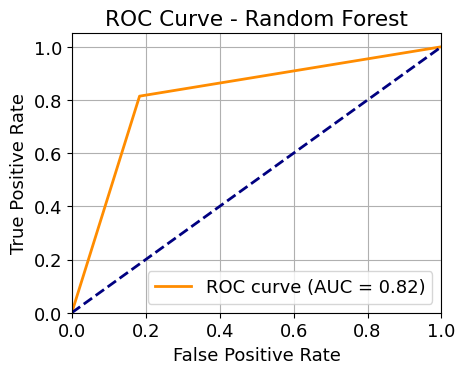

In [89]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_rf_predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.savefig("RF.png", dpi=600)
plt.show()

# KNN

In [90]:
# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
knn_param_grid = {
    'n_neighbors': range(1, len(X_train.columns), 2),  # Test odd values from 1 to 49 for the number of neighbors
    'algorithm': ['ball_tree', 'kd_tree']  # Test different algorithms for KNN
}

# Initialize the GridSearchCV with KNeighborsClassifier
knn_clf = GridSearchCV(knn, knn_param_grid, cv=5, n_jobs=-1)

knn_clf.fit(X_train, y_train)
print("Best parameters:", knn_clf.best_params_)

Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 127}


In [91]:
y_knn_predicted = knn_clf.predict(X_test)
knn_report = classification_report(y_test, y_knn_predicted)
print(knn_report)

              precision    recall  f1-score   support

           0       0.87      0.57      0.69        60
           1       0.71      0.93      0.81        70

    accuracy                           0.76       130
   macro avg       0.79      0.75      0.75       130
weighted avg       0.79      0.76      0.75       130



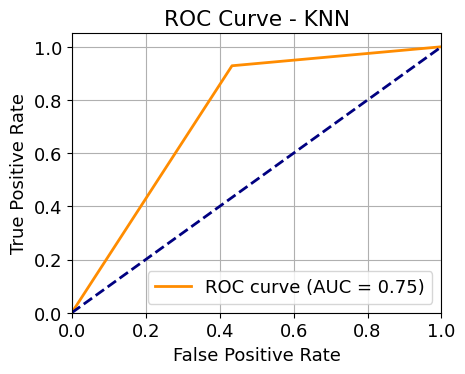

In [92]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_knn_predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.savefig("KNN.png", dpi=600)
plt.show()

# Decision Tree

In [158]:
# Instantiate DecisionTreeClassifier
print("Training DT..........")
dt = DecisionTreeClassifier()

# Define the parameter grid for GridSearchCV
dt_param_grid = {
    'criterion': ['gini', 'entropy'],           # Criterion for splitting
    'max_depth': [None, 10, 15, 20, 25, 30, 50, 80],    # Maximum depth of the tree
}

# Initialize GridSearchCV
dt_clf = GridSearchCV(dt, dt_param_grid, cv=5, n_jobs=-1)

dt_clf.fit(X_train, y_train)
print("Best parameters:", dt_clf.best_params_)

Training DT..........
Best parameters: {'criterion': 'gini', 'max_depth': 15}


In [159]:
y_dt_predicted = dt_clf.predict(X_test)
dt_report = classification_report(y_test, y_dt_predicted)
print(dt_report)

              precision    recall  f1-score   support

           0       0.72      0.73      0.73        60
           1       0.77      0.76      0.76        70

    accuracy                           0.75       130
   macro avg       0.74      0.75      0.74       130
weighted avg       0.75      0.75      0.75       130



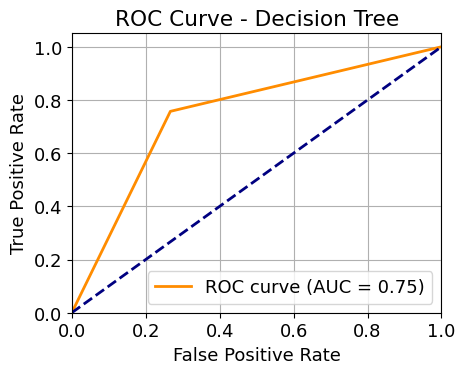

In [160]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_dt_predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.savefig("DT.png", dpi=600)
plt.show()

# XGBoost

In [161]:
# Instantiate XGBClassifier
XGB = xgb.XGBClassifier()

# Define the Pipeline
xgb_pipeline = Pipeline([
    ('pca', PCA()),
    ('model', XGB)
])

# Define the parameter grid for GridSearchCV
xgb_param_grid = {
    'pca__n_components': [3, 10, 20, 30, 50, 80],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
    'model__learning_rate': [0.1, 0.01, 0.001]
}

# Initialize GridSearchCV
xgb_clf = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, n_jobs=-1)

xgb_clf.fit(X_train, y_train)
print("Best parameters:", xgb_clf.best_params_)

Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'pca__n_components': 50}


In [162]:
y_xgb_predicted = xgb_clf.predict(X_test)
xgb_report = classification_report(y_test, y_xgb_predicted)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        60
           1       0.76      0.83      0.79        70

    accuracy                           0.77       130
   macro avg       0.77      0.76      0.77       130
weighted avg       0.77      0.77      0.77       130



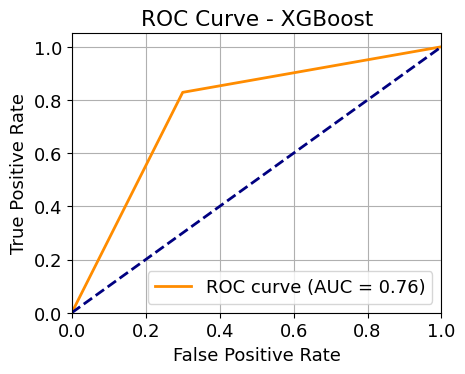

In [163]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_xgb_predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.savefig("XGB.png", dpi=600)
plt.show()

# SVM

In [93]:
# Initialize the Support Vector Classifier (SVC)
svm = SVC()

# Define the parameter grid for GridSearchCV
svm_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1,2, 2.5, 3, 3.5, 5, 10, 100],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
}

# Initialize the GridSearchCV with Support Vector Classifier (SVC)
svm_clf = GridSearchCV(svm, svm_param_grid, refit=True, verbose=2, n_jobs=-1)

svm_clf.fit(X_train, y_train)
print("Best parameters:", svm_clf.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [94]:
y_svm_predicted = svm_clf.predict(X_test)
svm_report = classification_report(y_test, y_svm_predicted)
print(svm_report)

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        60
           1       0.79      0.81      0.80        70

    accuracy                           0.78       130
   macro avg       0.78      0.78      0.78       130
weighted avg       0.78      0.78      0.78       130



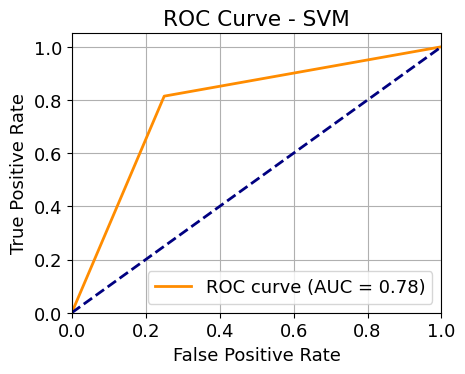

In [95]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_svm_predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.savefig("SVM.png", dpi=600)
plt.show()

# MLP

In [164]:
# Initialize the Multi Layer Perceptron (MLP)
mlp = MLPClassifier()

# Define the parameter grid for GridSearchCV for MLPClassifier
mlp_param_grid = {
    'hidden_layer_sizes': [(80, ), (100,), (100, 100, 50), (50, 100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
}

# Initialize the GridSearchCV with MLP
mlp_clf = GridSearchCV(mlp, mlp_param_grid, refit=True, verbose=2, n_jobs=-1)

mlp_clf.fit(X_train, y_train)
print("Best parameters:", mlp_clf.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (50, 100, 100), 'learning_rate': 'constant', 'solver': 'sgd'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(

In [165]:
y_mlp_predicted = mlp_clf.predict(X_test)
mlp_report = classification_report(y_test, y_mlp_predicted)
print(mlp_report)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        60
           1       0.82      0.83      0.82        70

    accuracy                           0.81       130
   macro avg       0.81      0.81      0.81       130
weighted avg       0.81      0.81      0.81       130



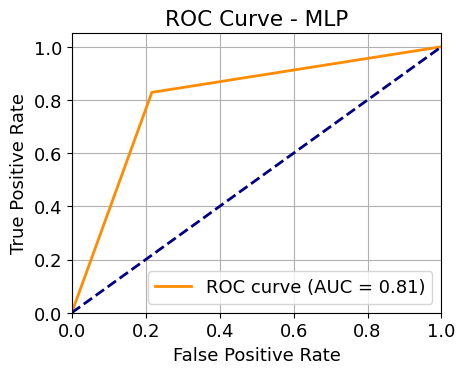

In [166]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_mlp_predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - MLP')
plt.legend(loc="lower right")
plt.savefig("MLP.png", dpi=600)
plt.show()

# Create random baseline classifier

In [156]:
# Create random baseline classifier
class RandomBaselineClassifier:
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.class_probs_ = np.bincount(y) / len(y)

    def predict(self, X):
        return np.random.choice(self.classes_, size=len(X), p=self.class_probs_)

# Create random baseline classifier instance
random_baseline_classifier = RandomBaselineClassifier()

# Train the classifier
random_baseline_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_random = random_baseline_classifier.predict(X_test)

# Calculate accuracy
baseline_report = classification_report(y_test, y_pred_random)
print(baseline_report)


              precision    recall  f1-score   support

           0       0.50      0.52      0.51        60
           1       0.57      0.56      0.57        70

    accuracy                           0.54       130
   macro avg       0.54      0.54      0.54       130
weighted avg       0.54      0.54      0.54       130



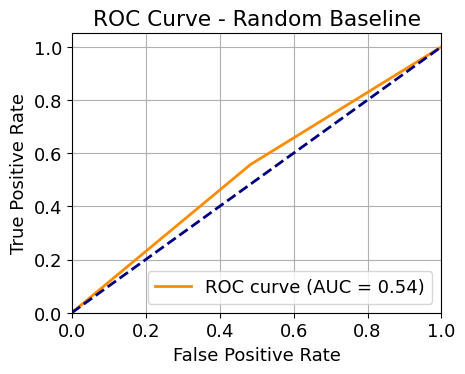

In [157]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 13
plt.rcParams["figure.figsize"] = (4.54, 4.54*0.8)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_random)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve - Random Baseline')
plt.legend(loc="lower right")
plt.savefig("baseline.png", dpi=600)
plt.show()

# Logistic Regression to check wether Shooting impact public satisfaction or not

In [169]:
import statsmodels.api as sm

X = data[['Fatal', 'Non-Fatal']]
y = data['overall_rating']

In [170]:
X.isna().sum()

Fatal        5
Non-Fatal    5
dtype: int64

In [172]:
X = X.fillna(X.mean())

In [173]:
X.isna().sum()

Fatal        0
Non-Fatal    0
dtype: int64

In [174]:
X = sm.add_constant(X)

In [175]:
X

,const,Fatal,Non-Fatal
0,1.0,10.0,27.0
1,1.0,10.0,27.0
2,1.0,31.0,192.0
3,1.0,6.0,40.0
4,1.0,9.0,39.0
...,...,...,...
644,1.0,9.0,32.0
645,1.0,9.0,39.0
646,1.0,31.0,192.0
647,1.0,0.0,2.0


In [176]:
reg_moded = sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.676945
         Iterations 4


In [177]:
print(reg_moded.summary())

                           Logit Regression Results                           
Dep. Variable:         overall_rating   No. Observations:                  649
Model:                          Logit   Df Residuals:                      646
Method:                           MLE   Df Model:                            2
Date:                Sat, 27 Apr 2024   Pseudo R-squ.:                 0.01790
Time:                        22:06:16   Log-Likelihood:                -439.34
converged:                       True   LL-Null:                       -447.35
Covariance Type:            nonrobust   LLR p-value:                 0.0003325
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2711      0.160      1.691      0.091      -0.043       0.585
Fatal          0.0935      0.040      2.345      0.019       0.015       0.172
Non-Fatal     -0.0175      0.006     -2.992      0.0